In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
from scipy.interpolate import griddata
import matplotlib.colors as colors

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit

from functools import reduce
import DataPreprocessing
import NLOPolynomialFeatures

In [2]:
mandel_str = ['1,3','2,3']

In [3]:
##Obtain & process data NPY
me_train, mom_train = DataPreprocessing.npy('NLO/MG_uuxg/me_1000000.npy', 'NLO/MG_uuxg/mom_1000000.npy', [], frac=0.01)
me_test, mom_test = DataPreprocessing.npy('NLO/MG_uuxg/me_100000.npy', 'NLO/MG_uuxg/mom_100000.npy', [], frac=0.01)

In [4]:
def error_plot(perc_error):
    s12, s13, s23 = DataPreprocessing.mandel_creation(['1,2','2,3','1,3'], mom_test)
    S = s12 + s13 + s23
    
    x1 = np.divide(s12, 1000000)
    x2 = np.divide(s13, 1000000)
    x3 = np.divide(s23, 1000000)

    x2i = np.linspace(0, 1, 500) #x1 coordinates
    x3i = np.linspace(0, 1, 500) #x2 coordinates
    X2i, X3i = np.meshgrid(x2i, x3i) #2d regularly spaced grid of coordinates.


    #grid = griddata((x2, x3), abs(temp_train), (X2i, X3i), method='linear')
    grid = griddata((x2, x3), perc_error, (X2i, X3i), method='linear')

    fig, ax = pyplot.subplots()
    im = ax.pcolor(grid, cmap = 'nipy_spectral_r', norm = colors.LogNorm()) #color map of coord grid
    cbar = ax.figure.colorbar(im)
    cbar.set_label('Matrix Element')

    ax.set_xticks([0, 500])
    ax.set_xticklabels([0, 1])
    ax.set_yticks([0, 500])
    ax.set_yticklabels([0, 1])


    ax.set_ylabel('x2')
    ax.set_xlabel('x3')

In [8]:
def error_smallest_S(perc_error, mom):
    mandel_vars = DataPreprocessing.mandel_creation(mandel_str, mom)
    min_mandel_vars = [min(mandel_var) for mandel_var in mandel_vars.T]
    pyplot.scatter(min_mandel_vars,perc_error)
    pyplot.xlabel('Minimum Mandelstam Variable')
    pyplot.ylabel('Percentage Error')
    pyplot.ylim(0,100)
    pyplot.savefig('PolynomialAtNLO')

In [9]:
from sklearn.preprocessing import PolynomialFeatures


def calc_RMSE(mom_train, mom_test_r, me_train, me_test, var_name):
    mom_test = mom_test_r
    if var_name == 'Finite':
        mom_train = NLOPolynomialFeatures.finitePolynomialFeatures(mandel_str, mom_train, 1000000)
        mom_test = NLOPolynomialFeatures.finitePolynomialFeatures(mandel_str, mom_test, 1000000)

    if var_name == 'Sing':
        mom_train = NLOPolynomialFeatures.r1PolynomialFeatures(mandel_str, mom_train,1000000)
        mom_test = NLOPolynomialFeatures.r1PolynomialFeatures(mandel_str, mom_test,1000000)
        
    
    mom_train = np.array([np.ndarray.flatten(np.array(element)) for element in mom_train])
    mom_test = np.array([np.ndarray.flatten(np.array(element)) for element in mom_test])

    if var_name == 'Born' or var_name == 'Doub': 
        poly_features = PolynomialFeatures(degree=2)
        mom_train = poly_features.fit_transform(mom_train)
        mom_test = poly_features.transform(mom_test)
        
        
    
    scaler = StandardScaler()
    mom_train = scaler.fit_transform(mom_train)
    mom_test = scaler.transform(mom_test)

    linreg = LinearRegression().fit(mom_train, me_train) #Linear fit
    pred = linreg.predict(mom_test) #Prediction on test set

    
    mse_test = mean_squared_error(me_test, pred) #Mean squared error on test set
    mse_train = mean_squared_error(me_train, linreg.predict(mom_train)) #Mean squared error on train set
    
    print('{} RMSE Test: {}'.format(var_name, np.sqrt(mse_test)))
    print('{} RMSE Train: {}'.format(var_name, np.sqrt(mse_train)))

    perc = np.mean(np.abs(100*np.divide(np.abs(me_test - pred), me_test)))
    print('{} Percentage Error: {}'.format(var_name, perc))
    
    if var_name=='Finite':
        #error_plot(np.abs(100*np.divide(np.abs(me_test - pred), me_test)))
        error_smallest_S(np.abs(100*np.divide(np.abs(me_test - pred), me_test)), mom_test_r)

Born RMSE Test: 2.4363409622498436e-09
Born RMSE Train: 9.708639818746673e-09
Born Percentage Error: 4.2135050667212984e-12
Finite RMSE Test: 15215.988833668058
Finite RMSE Train: 115.7583479917664
Finite Percentage Error: 5.202790473783785
Sing RMSE Test: 91.06045994581221
Sing RMSE Train: 23.138626427048433
Sing Percentage Error: 0.2209946449318458
Doub RMSE Test: 1.489709067459001e-09
Doub RMSE Train: 1.0346492731175164e-08
Doub Percentage Error: 2.4362822940934333e-11


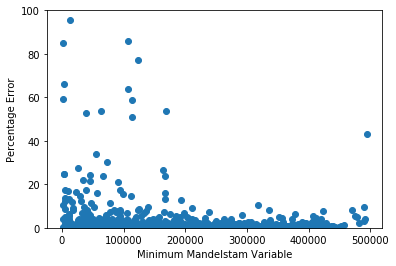

In [10]:
for i, name in enumerate(['Born', 'Finite', 'Sing', 'Doub']):
    div_train = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3','2,3'], mom_train))
    div_test = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3','2,3'], mom_test))
    
    temp_train = np.multiply(div_train, me_train[:,i])
    temp_test = np.multiply(div_test, me_test[:,i])
    
    if i == 1 or i == 2:
        div_train = reduce(np.multiply, 1-DataPreprocessing.mandel_creation(['1,3','2,3'], mom_train))
        div_test = reduce(np.multiply, 1-DataPreprocessing.mandel_creation(['1,3','2,3'], mom_test))

        temp_train = np.multiply(div_train, me_train[:,i])
        temp_test = np.multiply(div_test, me_test[:,i])
        
    calc_RMSE(mom_train, mom_test, temp_train, temp_test, name)

In [6]:
me_train[:,2]

array([-4.76930770e-08, -2.07651763e-08, -5.01843474e-08, ...,
       -1.03553235e-06, -6.30436798e-07, -1.91875940e-05])

In [35]:
div_train = reduce(np.multiply, 1-DataPreprocessing.mandel_creation(['1,3','2,3'], mom_train))
temp_train = np.multiply(div_train, me_train[:,1])

Text(0.5,0,'x3')

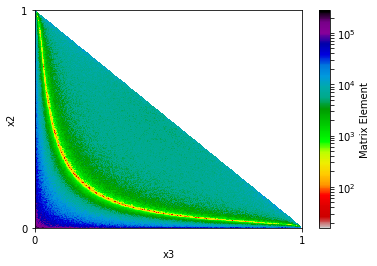

In [39]:
def error_plot(perc_error):
    s12, s13, s23 = DataPreprocessing.mandel_creation(['1,2','2,3','1,3'], mom_train)
    S = s12 + s13 + s23
    
    x1 = np.divide(s12, 1000000)
    x2 = np.divide(s13, 1000000)
    x3 = np.divide(s23, 1000000)

    x2i = np.linspace(0, 1, 500) #x1 coordinates
    x3i = np.linspace(0, 1, 500) #x2 coordinates
    X2i, X3i = np.meshgrid(x2i, x3i) #2d regularly spaced grid of coordinates.


    #grid = griddata((x2, x3), abs(temp_train), (X2i, X3i), method='linear')
    grid = griddata((x2, x3), perc_error, (X2i, X3i), method='linear')

    fig, ax = pyplot.subplots()
    im = ax.pcolor(grid, cmap = 'nipy_spectral_r', norm = colors.LogNorm()) #color map of coord grid
    cbar = ax.figure.colorbar(im)
    cbar.set_label('Matrix Element')

    ax.set_xticks([0, 500])
    ax.set_xticklabels([0, 1])
    ax.set_yticks([0, 500])
    ax.set_yticklabels([0, 1])


    ax.set_ylabel('x2')
    ax.set_xlabel('x3')